# 다중분류

## 1. 라이브러리 데이터 import

In [2]:
# 라이브러리 import 

import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score,roc_auc_score, mean_squared_error

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder



from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score


import warnings 
warnings.filterwarnings("ignore")


In [3]:
df = pd.read_csv("./df.csv", index_col=0)
df.head(3)

,credit.policy,int.rate,installment,log.annual.inc,dti,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,grade,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,0.1189,829.10,11.350407,19.48,5639.958333,28854,52.1,0,0,0,0,1,0,1,0,0,0,0
1,1,0.1071,228.22,11.082143,14.29,2760.000000,33623,76.7,0,0,0,0,1,1,0,0,0,0,0
2,1,0.1357,366.86,10.373491,11.63,4710.000000,3511,25.6,1,0,0,0,1,0,1,0,0,0,0


## 2. Feature Selection

### feature_importance로 변수 중요도 확인

In [3]:
target= 'grade'
y = df[target] # 종속변인 추출
X = df.drop(target, axis=1) # 종속변인+중복컬럼 제외

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

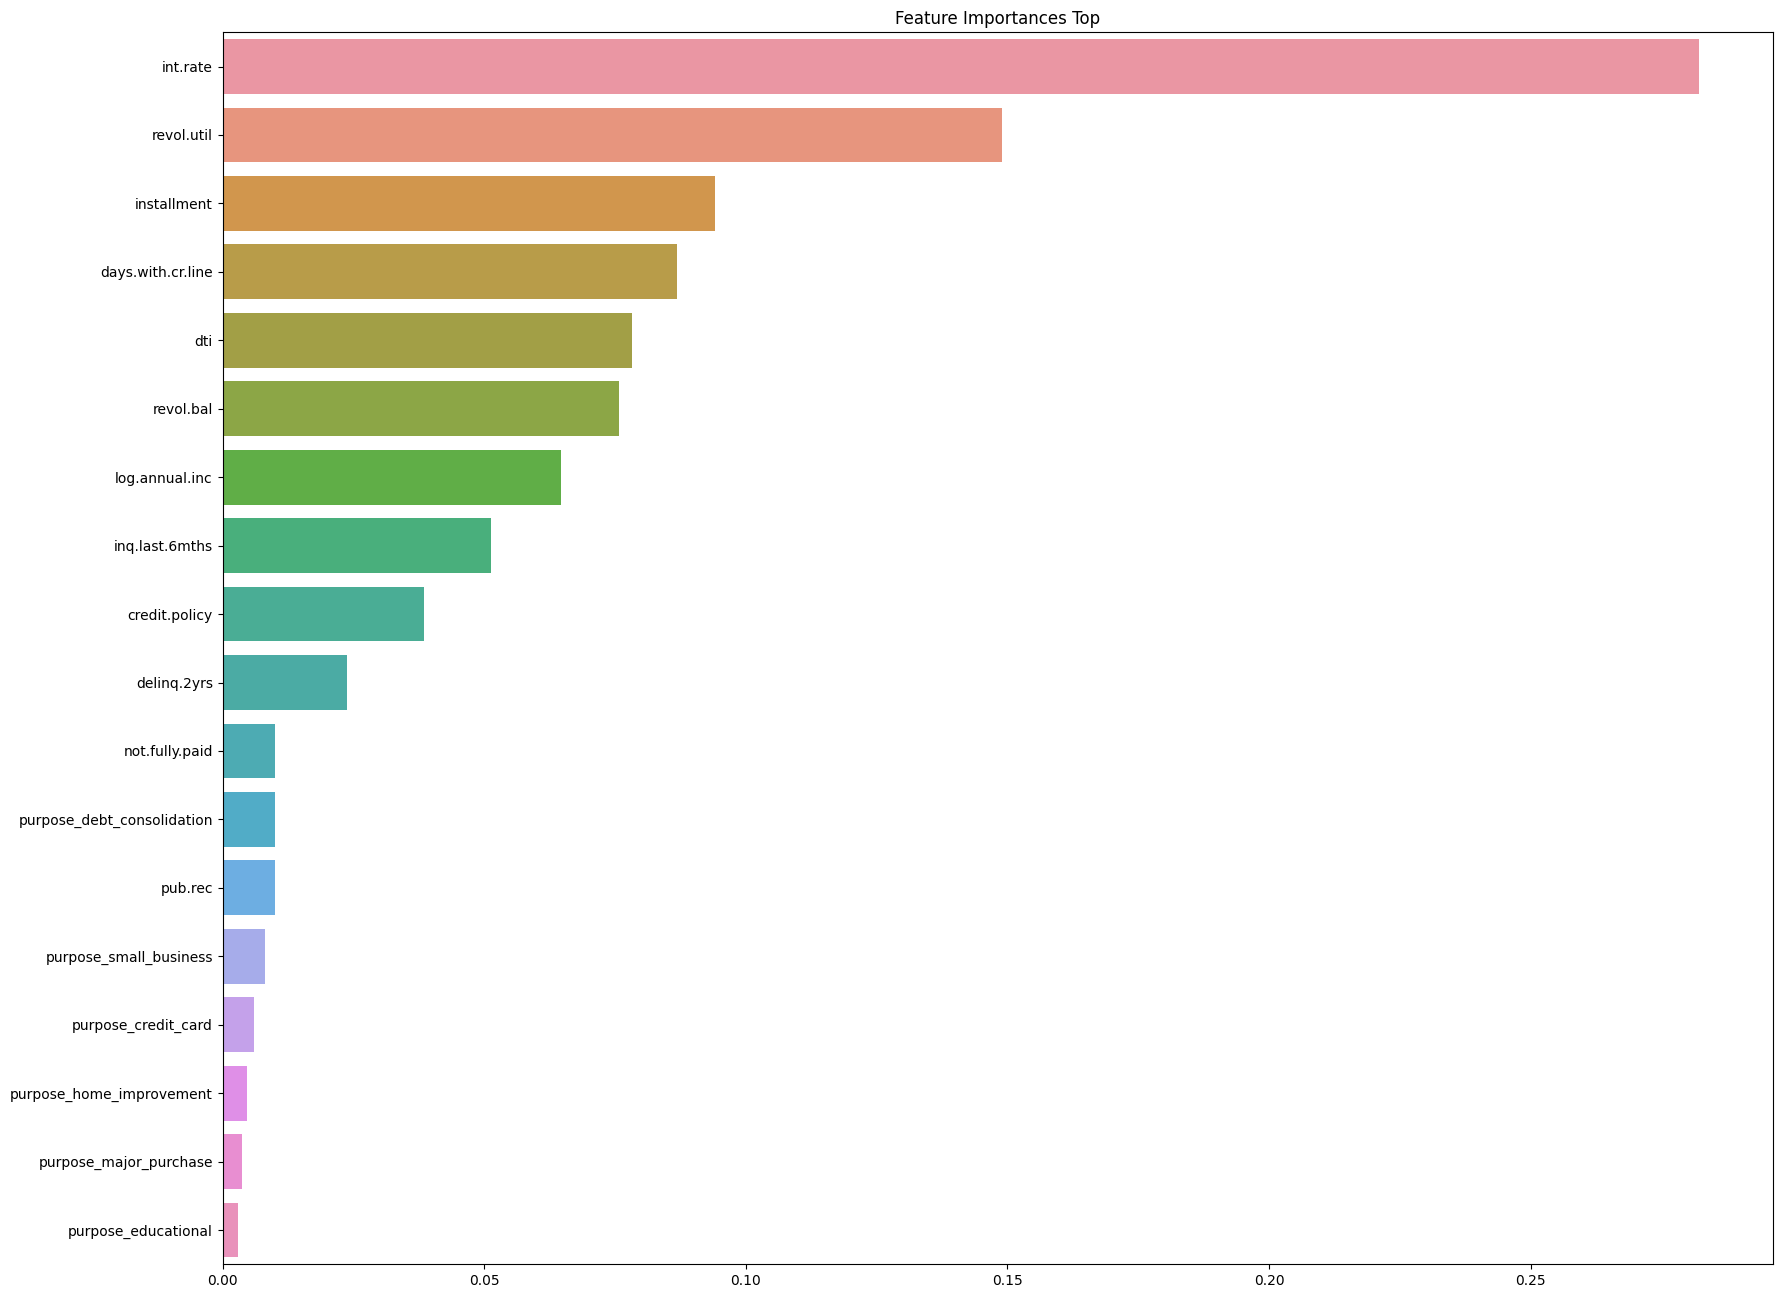

In [10]:
# feature imfortance 찍어보기

model = RandomForestClassifier(n_jobs=-1)
model.fit(X_train, y_train)
#feature 중요도도 그려볼 수 있다. 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df_non_label = X
# del df_non_label["Delay_from_due_date"]
# df_non_label.columns

feature_importances_values = model.feature_importances_
feature_importances = pd.Series(feature_importances_values, index=df_non_label.columns)
feature_importances_top20 = feature_importances.sort_values(ascending=False)[:53] #중요한 순서로 정렬 후 top 20개만 뽑아 시각화

plt.figure(figsize=(20, 16))
plt.title('Feature Importances Top')
sns.barplot(x=feature_importances_top20, y=feature_importances_top20.index)
plt.show()

In [4]:
# feature importance를 볼 수 있는 다른 방법
# permutation importance 는 feature 하나하나마다 shuffle을 하며 성능 변화를 지켜보고, 
# 만약 그 feature가 모델링에서 중요한 역할을 하고 있었다면 성능이 크게 떨어질 것이라는 개념으로 출발
# weight(성능 감소량)가 양수의 값을 가지는 변수들은 모델에 큰 영향을 끼친다는 의미이기 때문에 중요한 feature라고 판단할 수 있음.
# 반면 성능의 변화가 없거나(0), 음수의 값을 가지는 변수들은 모델에 큰 영향을 끼치지 못하는 중요하지 않은 feature라고 판단할 수 있음.

import eli5
from eli5.sklearn import PermutationImportance 
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier().fit(X_train, y_train)

perm = PermutationImportance(model, scoring = "accuracy", random_state = 22).fit(X_test, y_test) 
eli5.show_weights(perm, top = 20, feature_names = X_test.columns.tolist())

Weight,Feature
0.1952 ± 0.0065,int.rate
0.0938 ± 0.0093,credit.policy
0.0591 ± 0.0031,revol.util
0.0542 ± 0.0072,inq.last.6mths
0.0403 ± 0.0074,installment
0.0152 ± 0.0053,days.with.cr.line
0.0120 ± 0.0040,delinq.2yrs
0.0104 ± 0.0060,dti
0.0076 ± 0.0021,pub.rec
0.0073 ± 0.0038,log.annual.inc


### 상관관계 확인 

In [13]:
df.corr()

,credit.policy,int.rate,installment,log.annual.inc,dti,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,grade,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
credit.policy,1.000000,-0.294089,0.058770,0.034906,-0.090901,0.099026,-0.187518,-0.104095,-0.535511,-0.076318,-0.054243,-0.158119,0.360378,0.003216,0.020193,-0.031346,0.006036,0.024281,-0.003511
int.rate,-0.294089,1.000000,0.276140,0.056383,0.220006,-0.124022,0.092527,0.464837,0.202780,0.156079,0.098162,0.159552,-0.636835,-0.042109,0.123607,-0.019618,-0.050697,-0.068978,0.151247
installment,0.058770,0.276140,1.000000,0.448102,0.050202,0.183297,0.233625,0.081356,-0.010419,-0.004368,-0.032760,0.049955,0.074287,0.000774,0.161658,-0.094510,0.023024,-0.079836,0.145654
log.annual.inc,0.034906,0.056383,0.448102,1.000000,-0.054065,0.336896,0.372140,0.054881,0.029171,0.029203,0.016506,-0.033439,0.099375,0.072942,-0.026214,-0.119799,0.116375,-0.031020,0.091540
dti,-0.090901,0.220006,0.050202,-0.054065,1.000000,0.060101,0.188748,0.337109,0.029189,-0.021792,0.006209,0.037362,-0.203512,0.084476,0.179149,-0.035325,-0.092788,-0.077719,-0.069245
days.with.cr.line,0.099026,-0.124022,0.183297,0.336896,0.060101,1.000000,0.229344,-0.024239,-0.041736,0.081374,0.071826,-0.029237,0.223718,0.046220,-0.009318,-0.042621,0.068087,-0.020561,0.034883
revol.bal,-0.187518,0.092527,0.233625,0.372140,0.188748,0.229344,1.000000,0.203779,0.022394,-0.033243,-0.031010,0.053699,-0.014634,0.072316,0.005785,-0.034743,0.003258,-0.062395,0.083069
revol.util,-0.104095,0.464837,0.081356,0.054881,0.337109,-0.024239,0.203779,1.000000,-0.013880,-0.042740,0.066717,0.082088,-0.468435,0.091321,0.211869,-0.053128,-0.114449,-0.108079,-0.060962
inq.last.6mths,-0.535511,0.202780,-0.010419,0.029171,0.029189,-0.041736,0.022394,-0.013880,1.000000,0.021245,0.072673,0.149452,-0.171445,-0.033640,-0.044240,0.024243,0.043827,-0.001445,0.042567
delinq.2yrs,-0.076318,0.156079,-0.004368,0.029203,-0.021792,0.081374,-0.033243,-0.042740,0.021245,1.000000,0.009184,0.008881,-0.202250,-0.008817,-0.000697,-0.002214,-0.013098,0.004085,-0.004148


<AxesSubplot: >

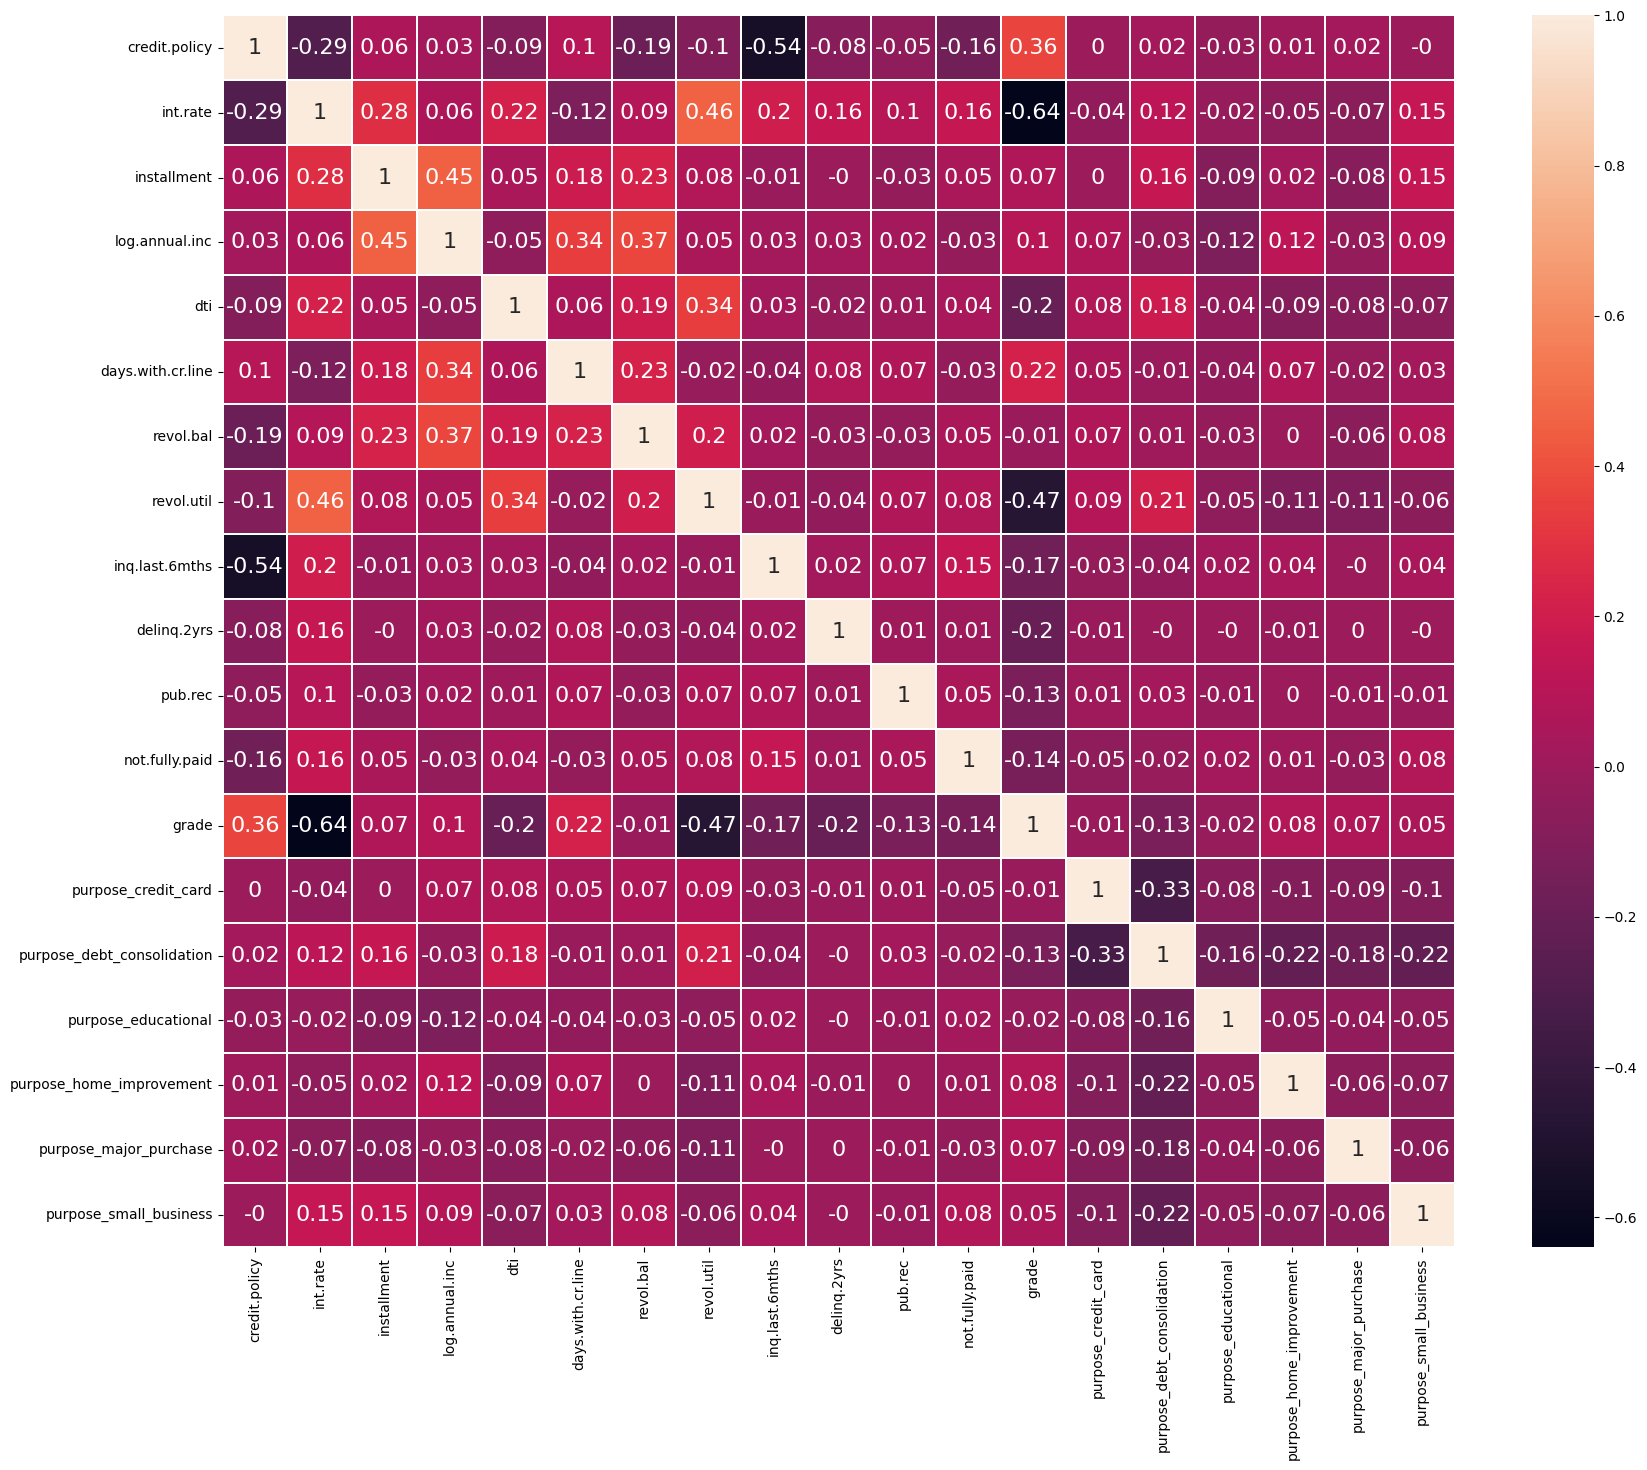

In [30]:
# 히트맵을 통해 상관계수 확인 

heatmap_data = df

plt.figure(figsize=(20, 16))
sns.heatmap(np.round(heatmap_data.astype(float).corr(),2), linewidths = 0.1, vmax = 1.0,
           square = True, linecolor = "white", annot = True, annot_kws = {"size" : 16})

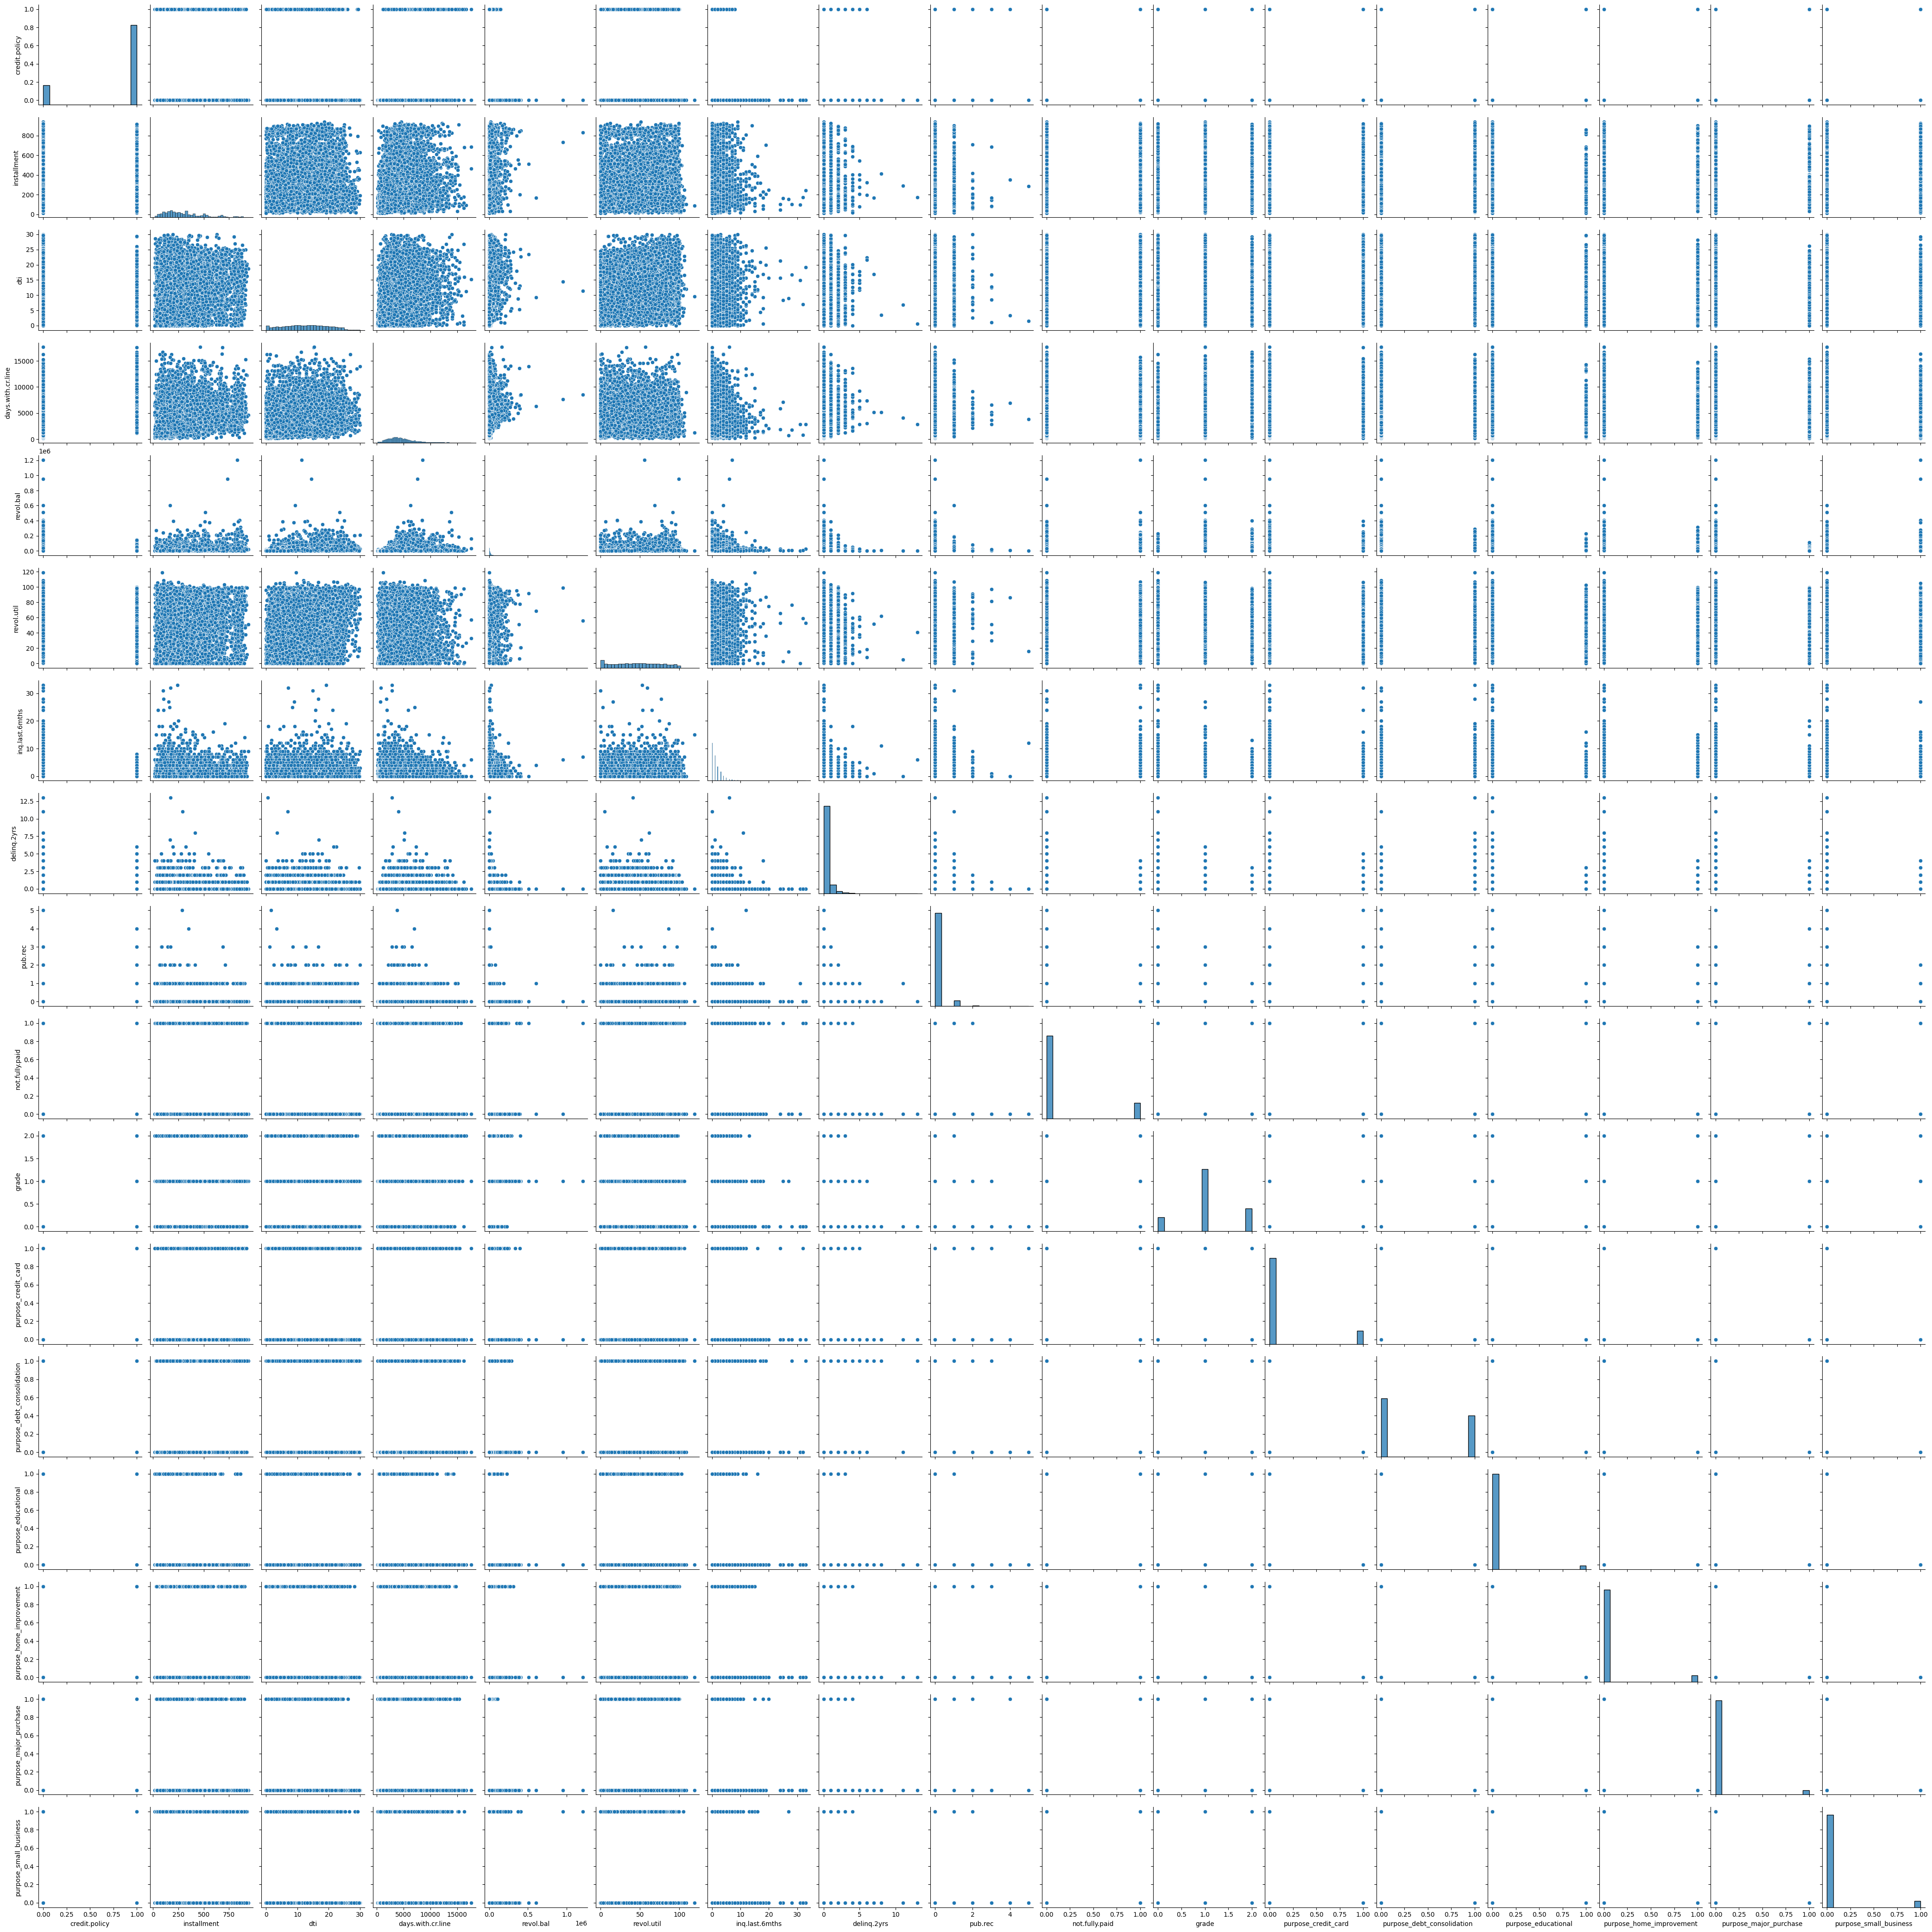

In [40]:
# seaborn의 차트를 이용한 데이터들의 상관관계 보기

sns.pairplot(df);

### VIF로 다중공선성 확인 

In [31]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    df.values, i) for i in range(df.shape[1])]
vif["features"] = df.columns
vif

,VIF Factor,features
0,8.681579,credit.policy
1,46.103881,int.rate
2,4.433096,installment
3,74.820266,log.annual.inc
4,5.182878,dti
5,5.359266,days.with.cr.line
6,1.613008,revol.bal
7,6.002115,revol.util
8,2.229814,inq.last.6mths
9,1.212147,delinq.2yrs


In [36]:
#vif 지수 높은 컬럼 제거하면서 나머지 컬럼들의 vif 지수 확인 

df_1 = df.drop("int.rate", axis=1)

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    df_1.values, i) for i in range(df_1.shape[1])]
vif["features"] = df_1.columns
vif

,VIF Factor,features
0,8.656562,credit.policy
1,4.104384,installment
2,28.285259,log.annual.inc
3,5.072234,dti
4,5.263974,days.with.cr.line
5,1.576546,revol.bal
6,5.604724,revol.util
7,2.209077,inq.last.6mths
8,1.200960,delinq.2yrs
9,1.100372,pub.rec


In [87]:
#vif 지수 높은 컬럼 제거하면서 나머지 컬럼들의 vif 지수 확인 

df_2 = df.drop(["log.annual.inc"], axis=1)

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    df_2.values, i) for i in range(df_2.shape[1])]
vif["features"] = df_2.columns
vif

,VIF Factor,features
0,7.874499,credit.policy
1,17.429238,int.rate
2,4.391769,installment
3,5.177677,dti
4,5.112274,days.with.cr.line
5,1.579344,revol.bal
6,5.986249,revol.util
7,2.149815,inq.last.6mths
8,1.208005,delinq.2yrs
9,1.101152,pub.rec


### 데이터 분할

In [4]:
# get_dummy를 통한 레이블 인코딩
y = pd.get_dummies(df["grade"])
x = df.drop("grade", axis=1)


x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=156, stratify=y)

In [5]:
x

,credit.policy,int.rate,installment,log.annual.inc,dti,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,0.1189,829.10,11.350407,19.48,5639.958333,28854,52.1,0,0,0,0,0,1,0,0,0,0
1,1,0.1071,228.22,11.082143,14.29,2760.000000,33623,76.7,0,0,0,0,1,0,0,0,0,0
2,1,0.1357,366.86,10.373491,11.63,4710.000000,3511,25.6,1,0,0,0,0,1,0,0,0,0
3,1,0.1008,162.34,11.350407,8.10,2699.958333,33667,73.2,1,0,0,0,0,1,0,0,0,0
4,1,0.1426,102.92,11.299732,14.97,4066.000000,4740,39.5,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9573,0,0.1461,344.76,12.180755,10.39,10474.000000,215372,82.1,2,0,0,1,0,0,0,0,0,0
9574,0,0.1253,257.70,11.141862,0.21,4380.000000,184,1.1,5,0,0,1,0,0,0,0,0,0
9575,0,0.1071,97.81,10.596635,13.09,3450.041667,10036,82.9,8,0,0,1,0,1,0,0,0,0
9576,0,0.1600,351.58,10.819778,19.18,1800.000000,0,3.2,5,0,0,1,0,0,0,1,0,0


### Resampling 여부를 정하기 위해 데이터 비율 보기 

In [91]:
y_train.value_counts()

0  1  2
0  1  0    4805
   0  1    1784
1  0  0    1073
dtype: int64

In [73]:
y_train.value_counts(normalize=True)

# 비율 확인 결과  Resampling은 필요 없어 보임

0  1  2
0  1  0    0.627121
   0  1    0.232837
1  0  0    0.140042
dtype: float64

In [10]:
de_clf = DecisionTreeClassifier(random_state=156)
ra_clf =RandomForestClassifier(random_state=156)
xgb =XGBClassifier()
knn = KNeighborsClassifier()

### Scailng

In [13]:
min_scal = MinMaxScaler()
std_scal = StandardScaler()
robu_scale = RobustScaler()

x_train_min = min_scal.fit_transform(x_train)
x_test_min = min_scal.fit_transform(x_test)

x_train_std = std_scal.fit_transform(x_train)
x_test_std = std_scal.fit_transform(x_test)

x_train_robu = robu_scale.fit_transform(x_train)
x_test_robu = robu_scale.fit_transform(x_test)

print(classification_report(y_test, de_clf.fit(x_train,y_train).predict(x_test)))
print(classification_report(y_test, de_clf.fit(x_train_min,y_train).predict(x_test_min))) 
print(classification_report(y_test, de_clf.fit(x_train_std,y_train).predict(x_test_std)))
print(classification_report(y_test, de_clf.fit(x_train_robu,y_train).predict(x_test_robu)))  

# precision    recall  f1-score   support

#            0       0.40      0.39      0.40       268
#            1       0.74      0.74      0.74      1202
#            2       0.61      0.61      0.61       446

#     accuracy                           0.66      1916
#    macro avg       0.58      0.58      0.58      1916
# weighted avg       0.66      0.66      0.66      1916

#               precision    recall  f1-score   support

#            0       0.28      0.38      0.33       268
#            1       0.71      0.62      0.66      1202
#            2       0.55      0.60      0.57       446

#     accuracy                           0.58      1916
#    macro avg       0.51      0.54      0.52      1916
# weighted avg       0.61      0.58      0.59      1916

#               precision    recall  f1-score   support

#            0       0.37      0.41      0.39       268
#            1       0.73      0.73      0.73      1202
#            2       0.60      0.55      0.57       446

# accuracy                           0.65      1916
#    macro avg       0.57      0.56      0.56      1916
# weighted avg       0.65      0.65      0.65      1916

#               precision    recall  f1-score   support

#            0       0.41      0.40      0.40       268
#            1       0.73      0.75      0.74      1202
#            2       0.60      0.56      0.58       446

#     accuracy                           0.66      1916
#    macro avg       0.58      0.57      0.57      1916
# weighted avg       0.65      0.66      0.66      1916

print(classification_report(y_test, ra_clf.fit(x_train,y_train).predict(x_test)))
print(classification_report(y_test, ra_clf.fit(x_train_min,y_train).predict(x_test_min)))
print(classification_report(y_test, ra_clf.fit(x_train_std,y_train).predict(x_test_std)))
print(classification_report(y_test, ra_clf.fit(x_train_robu,y_train).predict(x_test_robu)))
# precision    recall  f1-score   support

#            0       0.75      0.30      0.43       268
#            1       0.77      0.90      0.83      1202
#            2       0.77      0.70      0.73       446

#     accuracy                           0.77      1916
#    macro avg       0.77      0.64      0.67      1916
# weighted avg       0.77      0.77      0.75      1916

#               precision    recall  f1-score   support

#            0       0.71      0.27      0.39       268
#            1       0.78      0.89      0.83      1202
#            2       0.76      0.75      0.75       446

#     accuracy                           0.77      1916
#    macro avg       0.75      0.64      0.66      1916
# weighted avg       0.76      0.77      0.75      1916

#               precision    recall  f1-score   support

#            0       0.68      0.28      0.40       268
#            1       0.76      0.90      0.82      1202
#            2       0.77      0.66      0.71       446

#     accuracy                           0.76      1916
#    macro avg       0.74      0.61      0.64      1916
# weighted avg       0.75      0.76      0.74      1916

#               precision    recall  f1-score   support

#            0       0.72      0.28      0.41       268
#            1       0.76      0.90      0.83      1202
#            2       0.77      0.67      0.71       446

#     accuracy                           0.76      1916
#    macro avg       0.75      0.62      0.65      1916
# weighted avg       0.76      0.76      0.74      1916



print(classification_report(y_test, xgb.fit(x_train,y_train).predict(x_test)))
print(classification_report(y_test, xgb.fit(x_train_min,y_train).predict(x_test_min)))
print(classification_report(y_test, xgb.fit(x_train_std,y_train).predict(x_test_std)))
print(classification_report(y_test, xgb.fit(x_train_robu,y_train).predict(x_test_robu)))

# precision    recall  f1-score   support

#            0       0.76      0.34      0.47       268
#            1       0.79      0.90      0.84      1202
#            2       0.77      0.73      0.75       446

#     accuracy                           0.78      1916
#    macro avg       0.77      0.66      0.69      1916
# weighted avg       0.78      0.78      0.77      1916

#               precision    recall  f1-score   support

#            0       0.66      0.30      0.42       268
#            1       0.78      0.87      0.82      1202
#            2       0.74      0.74      0.74       446

#     accuracy                           0.76      1916
#    macro avg       0.73      0.64      0.66      1916
# weighted avg       0.75      0.76      0.74      1916

#               precision    recall  f1-score   support

#            0       0.68      0.31      0.42       268
#            1       0.76      0.89      0.82      1202
#            2       0.74      0.65      0.69       446

#     accuracy                           0.75      1916
#    macro avg       0.73      0.61      0.64      1916
# weighted avg       0.74      0.75      0.73      1916

#               precision    recall  f1-score   support

#            0       0.69      0.34      0.46       268
#             1       0.77      0.90      0.83      1202
#            2       0.79      0.66      0.72       446

#     accuracy                           0.77      1916
#    macro avg       0.75      0.64      0.67      1916
# weighted avg       0.76      0.77      0.75      1916




# 스케일 데이터 사용시와 원본 데이터 사용시 정확도에 큰 차이가 없어 스케일링은 필요 없어 보임  

              precision    recall  f1-score   support

           0       0.62      0.62      0.62       268
           1       0.82      0.82      0.82      1202
           2       0.72      0.72      0.72       446

   micro avg       0.77      0.77      0.77      1916
   macro avg       0.72      0.72      0.72      1916
weighted avg       0.77      0.77      0.77      1916
 samples avg       0.77      0.77      0.77      1916

              precision    recall  f1-score   support

           0       0.51      0.60      0.55       268
           1       0.80      0.79      0.79      1202
           2       0.74      0.67      0.70       446

   micro avg       0.74      0.74      0.74      1916
   macro avg       0.68      0.69      0.68      1916
weighted avg       0.74      0.74      0.74      1916
 samples avg       0.74      0.74      0.74      1916

              precision    recall  f1-score   support

           0       0.54      0.62      0.58       268
           1       0.

# 3. Model Score


In [14]:
from sklearn import metrics

def modeling(model,x_train,x_test,y_train,y_test):
    model.fit(x_train,y_train)
    pred = model.predict(x_test)
    print(classification_report(y_test,pred))

de_clf = DecisionTreeClassifier(random_state=156)
ra_clf =RandomForestClassifier(random_state=156)
xgb =XGBClassifier()
knn = KNeighborsClassifier()


In [15]:
# DecisionTreeClassifier를 이용한 머신러닝 
modeling(de_clf,x_train, x_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.62      0.62      0.62       268
           1       0.82      0.82      0.82      1202
           2       0.72      0.72      0.72       446

   micro avg       0.77      0.77      0.77      1916
   macro avg       0.72      0.72      0.72      1916
weighted avg       0.77      0.77      0.77      1916
 samples avg       0.77      0.77      0.77      1916



In [28]:
de_clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 156,
 'splitter': 'best'}

In [35]:
# RandomForestClassifier를 이용한 머신러닝
ra_clf =RandomForestClassifier(random_state=156)
modeling(ra_clf,x_train, x_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.84      0.51      0.64       268
           1       0.83      0.92      0.87      1202
           2       0.85      0.74      0.79       446

   micro avg       0.83      0.82      0.83      1916
   macro avg       0.84      0.72      0.77      1916
weighted avg       0.84      0.82      0.82      1916
 samples avg       0.82      0.82      0.82      1916



In [36]:
ra_clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 156,
 'verbose': 0,
 'warm_start': False}

In [17]:
# XGBClassifier를 이용한 머신러닝
modeling(xgb,x_train, x_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.77      0.70      0.73       268
           1       0.86      0.90      0.88      1202
           2       0.83      0.81      0.82       446

   micro avg       0.84      0.85      0.85      1916
   macro avg       0.82      0.80      0.81      1916
weighted avg       0.84      0.85      0.84      1916
 samples avg       0.83      0.85      0.83      1916



In [30]:
xgb.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [18]:
# KNeighborsClassifier를 이용한 머신러닝
modeling(knn,x_train, x_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.20      0.04      0.07       268
           1       0.67      0.76      0.71      1202
           2       0.48      0.28      0.35       446

   micro avg       0.62      0.55      0.58      1916
   macro avg       0.45      0.36      0.38      1916
weighted avg       0.56      0.55      0.54      1916
 samples avg       0.55      0.55      0.55      1916



In [31]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

### Gridsearchcv

In [19]:
# Number of trees in random forest
n_estimators = [100, 200, 300]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,4]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the param grid
param_dist = {'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap}

In [20]:
# 랜덤포레스트 gridsearcgcv
grid = GridSearchCV(estimator = ra_clf, param_grid = param_dist, scoring ='accuracy', cv = 3, refit=True, n_jobs=1, verbose=2)
grid.fit(x_train,y_train)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=156), n_jobs=1,
             param_grid={'bootstrap': [True, False], 'max_depth': [2, 4],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=2)

In [21]:
# grindsearchcv를 통한 best_estimator 

print("estimator : ",grid.best_estimator_)
print("params : ",grid.best_params_)

estimator :  RandomForestClassifier(max_depth=4, max_features='auto', min_samples_leaf=2,
                       random_state=156)
params :  {'bootstrap': True, 'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


In [22]:
# gridsearchcv 를 통해 얻은 estomator를 대입한 Randomforest
ra_clf_grid = RandomForestClassifier(bootstrap=True, max_depth=4,max_features="auto", min_samples_leaf=2 ,min_samples_split=2,n_estimators=100, random_state=156)
modeling(ra_clf_grid,x_train, x_test, y_train, y_test)

              precision    recall  f1-score   support

           0       1.00      0.03      0.05       268
           1       0.73      0.95      0.83      1202
           2       0.86      0.54      0.66       446

   micro avg       0.75      0.72      0.74      1916
   macro avg       0.86      0.50      0.51      1916
weighted avg       0.80      0.72      0.68      1916
 samples avg       0.72      0.72      0.72      1916



In [120]:
param_grid_={'booster' :['gbtree'],
                 'silent':[True],
                 'max_depth':[5,6,8],
                 'min_child_weight':[1,3,5],
                 'gamma':[0,1,2,3],
                 'nthread':[4],
                 'colsample_bytree':[0.5,0.8],
                 'colsample_bylevel':[0.9],
                 'n_estimators':[50],
                 'objective':['binary:logistic'],
                 'random_state':[2]}

gcv=GridSearchCV(xgb, param_grid=param_grid_, cv=3, scoring='f1', n_jobs=4)
gcv.fit(x_train, y_train)

[17:34:37] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.



GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=4,
             param_grid={'booster': ['gbtree'], 'colsample_bylevel': [0.9],
                         'colsample_bytree': [0.5, 0.8], 'gamma': [0, 1, 2, 3],
                         'max_depth': [5, 6, 8], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [50], 'nthread': [4],
                         'objective': ['binary:logistic'], 'random_state': [2],
                         'silent': [True]},
             scoring='f1')

In [121]:
print("estimator : ",gcv.best_estimator_)
print("params : ",gcv.best_params_)

estimator :  XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=0.9, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, nthread=4, num_parallel_tree=None,
              predictor=None, ...)
params :  {'booster': 'gbtree', 'colsample_bylevel': 0.9, 'colsample_bytree': 0.5, 'gamma': 0, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 50, 'nthread': 4, 'objective': 'binary:logistic', 'random_state': 2, 'silent': True}


In [123]:
xgb_grid=XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
                colsample_bylevel=0.9, colsample_bynode=None,
                colsample_bytree=0.5, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=5, max_leaves=None,
                min_child_weight=1, monotone_constraints=None,
                n_estimators=50, n_jobs=None, nthread=4, num_parallel_tree=None,
                predictor=None, random_state = 2, silent = True)

In [124]:
modeling(xgb_grid, x_train, x_test, y_train, y_test)

[17:40:30] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

              precision    recall  f1-score   support

           0       0.76      0.63      0.69       268
           1       0.83      0.91      0.87      1202
           2       0.84      0.81      0.82       446

   micro avg       0.82      0.85      0.83      1916
   macro avg       0.81      0.78      0.79      1916
weighted avg       0.82      0.85      0.83      1916
 samples avg       0.82      0.85      0.83      1916



### RandomizedSearchCV

### RandomForest

In [143]:
# Number of trees in random forest
n_estimators = [100, 200, 300]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,4]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the param grid
param_dist = {'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap}

In [144]:
randomgrid = RandomizedSearchCV(estimator = ra_clf,
                                param_distributions= param_dist,
                                cv = 5,
                                verbose=1,
                                n_jobs = 4,
                                scoring="accuracy",
                                random_state=156,
                                n_iter=500)

In [145]:
randomgrid.fit(x_train,y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=156),
                   n_iter=500, n_jobs=4,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 4],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 200, 300]},
                   random_state=156, scoring='accuracy', verbose=1)

In [148]:
print(randomgrid.best_estimator_)
print(randomgrid.best_params_)

RandomForestClassifier(max_depth=4, max_features='auto', min_samples_split=5,
                       n_estimators=300, random_state=156)
{'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 4, 'bootstrap': True}


In [147]:
ra_clf_2= RandomForestClassifier(max_depth=4, max_features='auto', min_samples_split=5,n_estimators=300, random_state=156)
modeling(ra_clf_2,x_train, x_test, y_train, y_test )

              precision    recall  f1-score   support

           0       1.00      0.03      0.05       268
           1       0.73      0.95      0.82      1202
           2       0.83      0.51      0.64       446

   micro avg       0.75      0.72      0.73      1916
   macro avg       0.85      0.50      0.50      1916
weighted avg       0.79      0.72      0.67      1916
 samples avg       0.72      0.72      0.72      1916



### XGBOOST

In [ ]:
param_dict = {
    'n_estimators' : [100,200,300,400,500],
    'learning_rate' : [0.01,0.05,0.1,0.15],
    'max_depth' : [3,5,7,10,15],
    'gamma' : [0,1,2,3],
    'colsample_bytree' : [0.8,0.9]
}


In [39]:
randomgrid_xgb = RandomizedSearchCV(estimator = xgb,
                                param_distributions= param_dist,
                                cv = 5,
                                verbose=1,
                                n_jobs = 4,
                                scoring="accuracy",
                                random_state=156,
                                n_iter=500)

In [40]:
randomgrid_xgb.fit(x_train,y_train) 

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[15:13:59] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_iter=500, n_jobs=4,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 4],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 200, 300]},
                   random_state=156, scoring='accuracy', verbose=1)

In [41]:
print(randomgrid_xgb.best_estimator_)
print(randomgrid_xgb.best_params_)

XGBClassifier(base_score=None, booster=None, bootstrap=True, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_features='auto',
              max_leaves=None, min_child_weight=None, min_samples_leaf=1,
              min_samples_split=2, missing=nan, monotone_constraints=None,
              n_estimators=300, ...)
{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 4, 'bootstrap': True}


In [43]:
xgb_1 = XGBClassifier(base_score=None, booster=None, bootstrap=True, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_features='auto',
              max_leaves=None, min_child_weight=None, min_samples_leaf=1,
              min_samples_split=2,  monotone_constraints=None,
              n_estimators=300)

In [44]:
modeling(xgb_1, x_train, x_test, y_train,y_test)

[15:15:40] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

              precision    recall  f1-score   support

           0       0.77      0.69      0.73       268
           1       0.85      0.88      0.86      1202
           2       0.84      0.81      0.83       446

   micro avg       0.84      0.84      0.84      1916
   macro avg       0.82      0.80      0.81      1916
weighted avg       0.83      0.84      0.84      1916
 samples avg       0.82      0.84      0.82      1916



---
# 최종 모델 선정
---

In [6]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(x_train, y_train)
pred = xgb.predict(x_test)
print(classification_report(y_test, pred))
accuracy_score(y_test, pred)

              precision    recall  f1-score   support

           0       0.77      0.70      0.73       268
           1       0.86      0.90      0.88      1202
           2       0.83      0.81      0.82       446

   micro avg       0.84      0.85      0.85      1916
   macro avg       0.82      0.80      0.81      1916
weighted avg       0.84      0.85      0.84      1916
 samples avg       0.83      0.85      0.83      1916



0.8042797494780793